<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/ballymore_s_ndvi_3group_DSM_INDICES_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#unzip
!unzip -q "/content/drive/MyDrive/Ballymore.zip" -d "/content/dataset"

replace /content/dataset/Ballymore/Elevation/DSM_CLIP.tfw? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Ballymore/Elevation/DSM_CLIP.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Ballymore/Elevation/DSM_CLIP.tif.aux.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Ballymore/Elevation/DSM_CLIP.tif.enp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Ballymore/Elevation/DSM_CLIP.tif.ovr? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Ballymore/Elevation/MAGL.tfw? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Ballymore/Elevation/MAGL.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Ballymore/Elevation/MAGL.tif.aux.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Ballymore/Elevation/MAGL.tif.enp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Ballymore/Elevation/MAGL.tif.ovr? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [34]:
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [35]:
S_RGB_PATH = '/content/dataset/Ballymore/RGB/RGB.tif'
S_NDVI_PATH = '/content/dataset/Ballymore/NDVI/NDVI_cLIP.tif'
S_DSM = '/content/dataset/Ballymore/Elevation/DSM_CLIP.tif'

SHP_PATH = '/content/dataset/Ballymore/Info/Ballymore_habitat_map2018_ITM.shp'

In [ ]:
S_DSM = '/content/dataset/Ballymore/Elevation/DSM_CLIP.tif'

In [36]:
import rasterio

# Check CRS of all files
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_DSM) as sd:
    print(f"Summer RGB CRS: {sr.crs}")
    print(f"Summer DSM CRS: {sd.crs}")
    gdf = gpd.read_file(SHP_PATH)
    print(f"Shapefile CRS:  {gdf.crs}")

# If they don't match, we must reproject the Shapefile to match the Raster
gdf = gdf.to_crs(sr.crs)

Summer RGB CRS: EPSG:32629
Summer DSM CRS: EPSG:32629
Shapefile CRS:  EPSG:2157


In [37]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os # Import the os module

dst_crs = 'EPSG:2157'
S_RGB_ITM_PATH = '/content/drive/MyDrive/ballymore/RGB_ITM.tif' # New path for the reprojected RGB file

# Create the directory if it does not exist
os.makedirs(os.path.dirname(S_RGB_ITM_PATH), exist_ok=True)

with rasterio.open(S_RGB_PATH) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(S_RGB_ITM_PATH, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, [1, 2, 3]),
            destination=rasterio.band(dst, [1, 2, 3]),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear)

In [38]:
print(gdf.columns)

Index(['Id', 'FossittTyp', 'FossittCod', 'EUType', 'EUCode', 'Habitat',
       'ClassID', 'geometry'],
      dtype='object')


In [39]:
LABEL_COL = 'Id'
NAME_COL = 'FossittCod'

gdf = gpd.read_file(SHP_PATH)

In [40]:
fossitt_merger = {
    # Peatlands (P)
    'PF1': 'Peatlands','PF3': 'Peatlands','PF1/PF3': 'Peatlands',
    'PB1': 'Peatlands', 'PF3/GM1': 'Peatlands', # Fens/Swamps are peat-forming

    # Grasslands (G)
    'GM1': 'Grasslands',

    # Woodland & Scrub (W)
    'WS1/GS2': 'Woodland_Scrub',
    'WS1/PB4': 'Woodland_Scrub'
}

gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

In [41]:
display(gdf.head())

,Id,FossittTyp,FossittCod,EUType,EUCode,Habitat,ClassID,geometry,merged_name
0,0,Transition mire and quaking bog,PF3,Transition mires and quaking bogs,7140,Carex-Menyanthes transition mire,1,"POLYGON ((623840.615 749398.629, 623840.383 74...",Peatlands
1,0,Rich fen and flush,PF1,Alkaline fen,7230,Juncus subnodulosus fen,2,"POLYGON ((624140.421 749654.68, 624140.421 749...",Peatlands
2,0,Rich fen and flush/Transition mire and quaking...,PF1/PF3,Alkaline fen/Transition mires and quaking bogs,7230/7140,Mosaic Schoenus-Carex fen/Menyanthes pool,5,"POLYGON ((624072.967 749720.969, 624079.765 74...",Peatlands
3,0,Raised bog,PB1,None,None,Calluna - Eriophorum bog,3,"POLYGON ((624290.903 749508.365, 624289.904 74...",Peatlands
4,0,Rich fen and flush,PF1,Alkaline fen,7230,Juncus subnodulosus fen,2,"POLYGON ((624211.264 749250.925, 624204.318 74...",Peatlands


In [42]:
all_pixels, all_labels = [], []

# --- 2. COORDINATED EXTRACTION ---
# Open all 4 sources (Note: W_RGB_PATH and W_NDVI_PATH are not defined and need to be added to the with statement if 4 sources are desired)
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn:
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

    print("Extracting features...")
    for idx, row in gdf.iterrows():
        try:
            poly = row.geometry
            min_x, min_y, max_x, max_y = poly.bounds
            points = []
            for _ in range(1000):
                pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
                if Point(pt).within(poly): points.append(pt)
                if len(points) >= 300: break

            if not points: continue

            # Sample all 4 rasters (Currently only summer rasters are sampled due to missing winter raster definitions)
            s_rgb_vals = np.array(list(sr.sample(points))).astype('float32')
            s_ndvi_vals = np.array(list(sn.sample(points))).astype('float32')


            # Feature Engineering
            # 1-6: Summer RGB + Winter RGB
            # 7-8: Summer NDVI + Winter NDVI
            # 9-10: Summer VARI + Winter VARI (Calculated from RGB)
            s_vari = (s_rgb_vals[:,1]-s_rgb_vals[:,0]) / (s_rgb_vals[:,1]+s_rgb_vals[:,0]-s_rgb_vals[:,2]+1e-5)


            combined = np.column_stack([
                s_rgb_vals, # w_rgb_vals would be undefined
                s_ndvi_vals, # w_ndvi_vals would be undefined
                s_vari # w_vari and delta_ndvi would be undefined
            ])

            valid = np.any(s_rgb_vals > 0, axis=1)
            if np.any(valid):
                all_pixels.append(combined[valid])
                all_labels.extend([row['merged_name']] * np.sum(valid))
        except: continue

X, y = np.vstack(all_pixels), np.array(all_labels)

Extracting features...


In [43]:
print(f"Total training samples: {len(X)}")

Total training samples: 5058


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Final Multi-Source Seasonal Report ---")
print(classification_report(y_test, rf.predict(X_test)))



--- Final Multi-Source Seasonal Report ---
                precision    recall  f1-score   support

    Grasslands       0.33      0.07      0.12       171
     Peatlands       0.78      0.96      0.86      1167
Woodland_Scrub       0.37      0.11      0.17       180

      accuracy                           0.76      1518
     macro avg       0.50      0.38      0.38      1518
  weighted avg       0.68      0.76      0.70      1518



In [45]:
import numpy as np
from scipy import ndimage

In [46]:
def get_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    for _ in range(num_points * 3): # 3x attempts to find points within poly
        pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if Point(pt).within(poly):
            points.append(pt)
        if len(points) >= num_points:
            break
    return points

In [47]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

    print("Extracting 6 Summer Features...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 300)
        if not pts: continue

        # Sample summer rasters at point locations
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()

        # Feature Engineering
        s_vari = (s_rgb[:,1]-s_rgb[:,0]) / (s_rgb[:,1]+s_rgb[:,0]-s_rgb[:,2]+1e-5)

        # Combine into 6-column stack
        combined = np.column_stack([
            s_rgb,           # 1-3: Summer RGB
            s_nd,            # 4: Summer NDVI
            s_vari,          # 5: Summer VARI
            s_h              # 6: Summer Height (DSM)
        ])

        # Filter: Ensure Summer RGB is not black
        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        num_valid = valid_pixels.shape[0]

        if num_valid > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * num_valid)

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Final Data Sync: X={X.shape}, y={y.shape}")

Extracting 6 Summer Features...
Final Data Sync: X=(4940, 7), y=(4940,)


In [48]:
print(f"Total training samples: {len(X)}")

Total training samples: 4940



--- Final Multi-Source Seasonal Report (Summer Features Only) ---
                precision    recall  f1-score   support

    Grasslands       0.61      0.12      0.20       158
     Peatlands       0.80      0.97      0.88      1144
Woodland_Scrub       0.61      0.19      0.30       180

      accuracy                           0.79      1482
     macro avg       0.68      0.43      0.46      1482
  weighted avg       0.76      0.79      0.73      1482



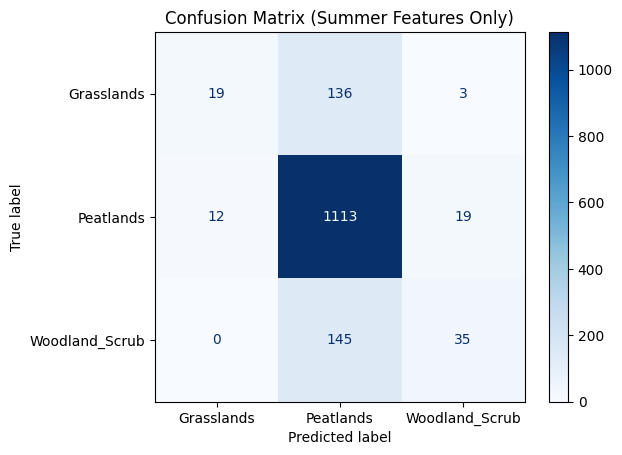

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Final Multi-Source Seasonal Report (Summer Features Only) ---")
print(classification_report(y_test, rf.predict(X_test)))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf.predict(X_test), labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Summer Features Only)')
plt.show()

Original training set shape: Counter({np.str_('Peatlands'): 2671, np.str_('Woodland_Scrub'): 420, np.str_('Grasslands'): 367})
Resampled training set shape: Counter({np.str_('Peatlands'): 2671, np.str_('Woodland_Scrub'): 2671, np.str_('Grasslands'): 2671})

--- Multi-Source Seasonal Report with SMOTE (Summer Features Only) ---
                precision    recall  f1-score   support

    Grasslands       0.33      0.42      0.37       158
     Peatlands       0.84      0.80      0.82      1144
Woodland_Scrub       0.36      0.40      0.38       180

      accuracy                           0.71      1482
     macro avg       0.51      0.54      0.52      1482
  weighted avg       0.73      0.71      0.72      1482



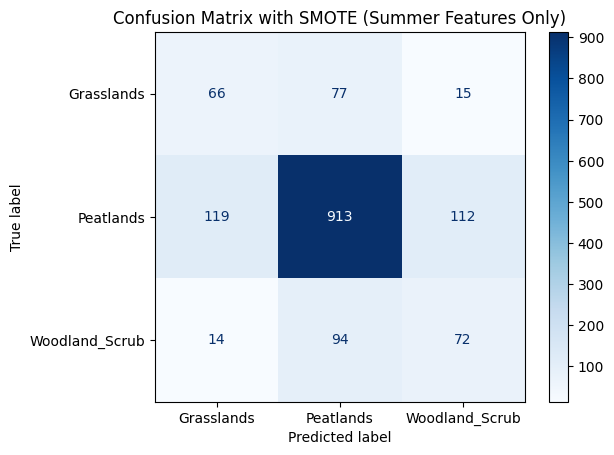

In [50]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print(f"Original training set shape: {Counter(y_train)}")

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(f"Resampled training set shape: {Counter(y_resampled)}")

# Retrain the Random Forest Classifier with the resampled data
rf_resampled = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf_resampled.fit(X_resampled, y_resampled)

print("\n--- Multi-Source Seasonal Report with SMOTE (Summer Features Only) ---")
print(classification_report(y_test, rf_resampled.predict(X_test)))

# Display the confusion matrix for the resampled model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_resampled = confusion_matrix(y_test, rf_resampled.predict(X_test), labels=rf_resampled.classes_)
disp_resampled = ConfusionMatrixDisplay(confusion_matrix=cm_resampled, display_labels=rf_resampled.classes_)
disp_resampled.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with SMOTE (Summer Features Only)')
plt.show()

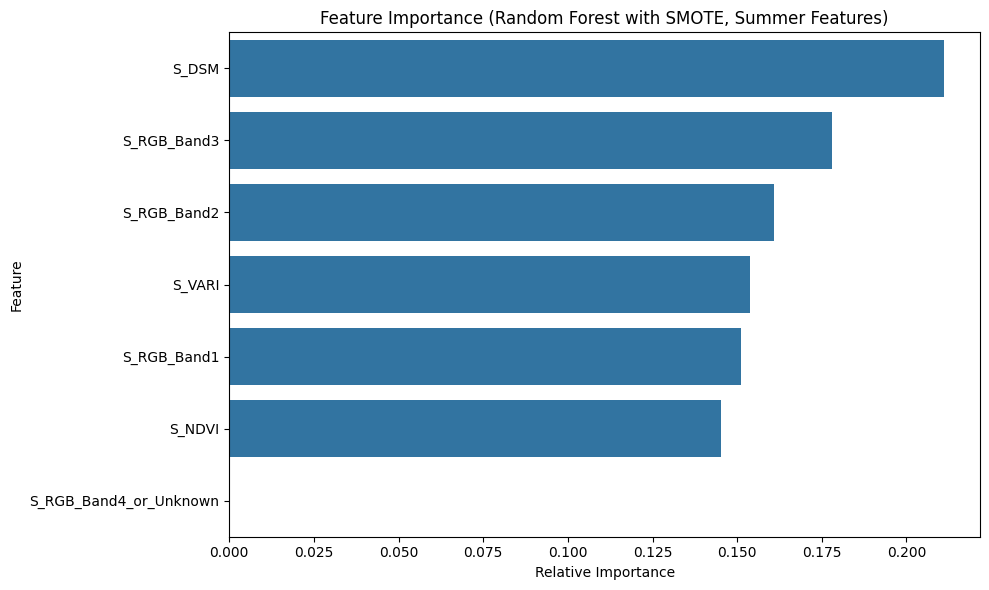

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from the trained model
importances = rf_resampled.feature_importances_

# Create feature names based on how they were combined in 'combined' array
feature_names = [
    'S_RGB_Band1', 'S_RGB_Band2', 'S_RGB_Band3',
    'S_NDVI',
    'S_VARI',
    'S_DSM'
]

# Check if the number of feature importances matches the expected number of features (7, as X.shape is (..., 7))
# The model trained on 7 features (S_RGB has 3 bands, S_NDVI, S_VARI, S_DSM). Let's adjust feature names to match.
# It seems `combined` was constructed with 6 actual features (3 RGB, 1 NDVI, 1 VARI, 1 DSM).
# Let's verify the number of features that rf_resampled was trained on

num_features_trained = rf_resampled.n_features_in_

# Adjust feature_names to match the number of features in X (X.shape is (5028, 7), so there are 7 features)
# Let's assume the 7th feature is an additional band from s_rgb, which was not explicitly accounted for in the comments
# For now, let's create generic names if the explicit names don't match up to 7
if num_features_trained == 7:
    feature_names = [
        'S_RGB_Band1', 'S_RGB_Band2', 'S_RGB_Band3', 'S_RGB_Band4_or_Unknown',
        'S_NDVI',
        'S_VARI',
        'S_DSM'
    ]
elif num_features_trained == 6:
    feature_names = [
        'S_RGB_Band1', 'S_RGB_Band2', 'S_RGB_Band3',
        'S_NDVI',
        'S_VARI',
        'S_DSM'
    ]
else:
    feature_names = [f'Feature_{i+1}' for i in range(num_features_trained)]


# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Random Forest with SMOTE, Summer Features)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [52]:
from collections import Counter

print(f"Samples per class in training set: {Counter(y_train)}")
print(f"Samples per class in testing set:  {Counter(y_test)}")

Samples per class in training set: Counter({np.str_('Peatlands'): 2671, np.str_('Woodland_Scrub'): 420, np.str_('Grasslands'): 367})
Samples per class in testing set:  Counter({np.str_('Peatlands'): 1144, np.str_('Woodland_Scrub'): 180, np.str_('Grasslands'): 158})


In [53]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(sampling_strategy='all', replacement=True)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier()


--- Balanced Random Forest Classifier Report ---
                precision    recall  f1-score   support

    Grasslands       0.26      0.51      0.34       158
     Peatlands       0.85      0.64      0.73      1144
Woodland_Scrub       0.29      0.52      0.38       180

      accuracy                           0.61      1482
     macro avg       0.47      0.56      0.48      1482
  weighted avg       0.72      0.61      0.65      1482



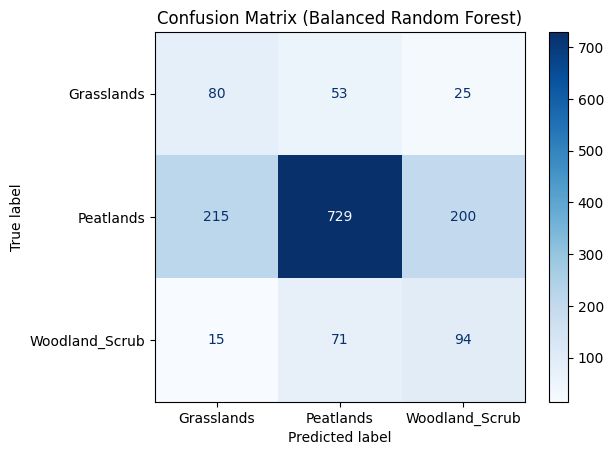

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n--- Balanced Random Forest Classifier Report ---")
print(classification_report(y_test, brf.predict(X_test)))

cm_brf = confusion_matrix(y_test, brf.predict(X_test), labels=brf.classes_)
disp_brf = ConfusionMatrixDisplay(confusion_matrix=cm_brf, display_labels=brf.classes_)
disp_brf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Balanced Random Forest)')
plt.show()

In [55]:
# Instead of equalizing everyone to ~300,
# allow Peatlands to keep a larger presence.
sampling_strategy = {
    'Peatlands': 1000,   # Keep more of the majority to reduce false positives
    'Woodland_Scrub': 420,
    'Grasslands': 358
}

brf = BalancedRandomForestClassifier(sampling_strategy=sampling_strategy, random_state=42)

In [56]:
# 1. Train the model
brf.fit(X_train, y_train)

# 2. Make new predictions
y_pred_new = brf.predict(X_test)

# 3. Check if Precision improved
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_new))

                precision    recall  f1-score   support

    Grasslands       0.46      0.26      0.33       158
     Peatlands       0.83      0.91      0.86      1144
Woodland_Scrub       0.45      0.34      0.39       180

      accuracy                           0.77      1482
     macro avg       0.58      0.50      0.53      1482
  weighted avg       0.74      0.77      0.75      1482



In [57]:
sampling_strategy = {
    'Peatlands': 700,  # Try a middle ground between 350 and 1000
    'Woodland_Scrub': 420,
    'Grasslands': 358
}

In [58]:
# 1. Train the model
brf.fit(X_train, y_train)

# 2. Make new predictions
y_pred_new = brf.predict(X_test)

# 3. Check if Precision improved
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_new))

                precision    recall  f1-score   support

    Grasslands       0.46      0.26      0.33       158
     Peatlands       0.83      0.91      0.86      1144
Woodland_Scrub       0.45      0.34      0.39       180

      accuracy                           0.77      1482
     macro avg       0.58      0.50      0.53      1482
  weighted avg       0.74      0.77      0.75      1482



In [59]:
def calculate_local_slope(window, res):
    """Calculates the maximum slope from a 3x3 window of elevation data."""
    if window.shape != (3, 3):
        return 0.0
    # Sobel-like filters for horizontal and vertical gradients
    dz_dx = ((window[0, 2] + 2 * window[1, 2] + window[2, 2]) -
             (window[0, 0] + 2 * window[1, 0] + window[2, 0])) / (8 * res)
    dz_dy = ((window[2, 0] + 2 * window[2, 1] + window[2, 2]) -
             (window[0, 0] + 2 * window[0, 1] + window[0, 2])) / (8 * res)
    slope = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2)) * (180 / np.pi)
    return slope

In [60]:
all_pixels, all_labels = [], []

# Using only Summer paths since Winter data is unavailable
with rasterio.open(S_RGB_PATH) as sr, \
     rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd:

    RES = sd.res[0]
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)

    # Map the labels (Using your column name 'FossittCod' from previous cells)
    gdf['merged_name'] = gdf['FossittCod'].replace(fossitt_merger)

    print("Extracting 14 Features (Summer Spectral + Height + Slope + Advanced Indices)...")

    for idx, row in gdf.iterrows():
        # Get random points within the polygon
        pts = get_random_points(row.geometry, 300)
        if not pts: continue

        # 1. Base Sampling (Summer Only)
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()

        # 2. Slope Sampling
        s_slopes = []
        for pt in pts:
            r_idx, c_idx = sd.index(pt[0], pt[1])
            # Define a 3x3 window around the point
            win = rasterio.windows.Window(c_idx - 1, r_idx - 1, 3, 3)
            s_win = sd.read(1, window=win, boundless=True, fill_value=0)
            s_slopes.append(calculate_local_slope(s_win, RES))

        # 3. Safe NIR Back-calculation
        # NDVI = (NIR - R) / (NIR + R) -> NIR = R * (1 + NDVI) / (1 - NDVI)
        s_nd_safe = np.clip(s_nd, -0.99, 0.99)
        s_nir = s_rgb[:, 0] * (1 + s_nd_safe) / (1 - s_nd_safe + 1e-5)

        # 4. Advanced Indices Calculation
        def calc_indices(r, g, b, nir):
            eps = 1e-5
            rvi = nir / (r + eps)
            savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
            evi = 2.5 * ((nir - r) / (nir + 6 * r - 7.5 * b + 1 + eps))
            gndvi = (nir - g) / (nir + g + eps)
            grvi = (g - r) / (g + r + eps)
            nrvi = (rvi - 1) / (rvi + 1 + eps)
            ndwi = (g - nir) / (g + nir + eps)
            vari = (g - r) / (g + r - b + eps)
            return np.column_stack([rvi, savi, evi, gndvi, grvi, nrvi, ndwi, vari])

        s_idx_stack = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)

        # 5. Final Assembly (14 Features Total)
        combined = np.column_stack([
            s_rgb,              # 1-3: RGB
            s_nd,               # 4: NDVI
            s_h,                # 5: DSM Height
            s_nir,              # 6: Calculated NIR
            s_idx_stack,        # 7-14: (RVI, SAVI, EVI, GNDVI, GRVI, NRVI, NDWI, VARI)
            s_slopes            # 15: Local Slope
        ])

        # Mask out background/null pixels (where RGB is all 0)
        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]

        if valid_pixels.shape[0] > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * valid_pixels.shape[0])

# Stack and Clean for Random Forest
X = np.vstack(all_pixels)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.array(all_labels)

print(f"Extraction Complete: X shape is {X.shape}")

Extracting 14 Features (Summer Spectral + Height + Slope + Advanced Indices)...
Extraction Complete: X shape is (4993, 16)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [62]:
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=700, n_jobs=-1,
                       random_state=42)

In [63]:
y_pred = rf.predict(X_test)
print("\n--- FINAL 32-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 32-FEATURE REPORT ---
                precision    recall  f1-score   support

    Grasslands       0.50      0.07      0.12       155
     Peatlands       0.79      0.98      0.88      1163
Woodland_Scrub       0.71      0.15      0.25       180

      accuracy                           0.79      1498
     macro avg       0.67      0.40      0.42      1498
  weighted avg       0.75      0.79      0.72      1498



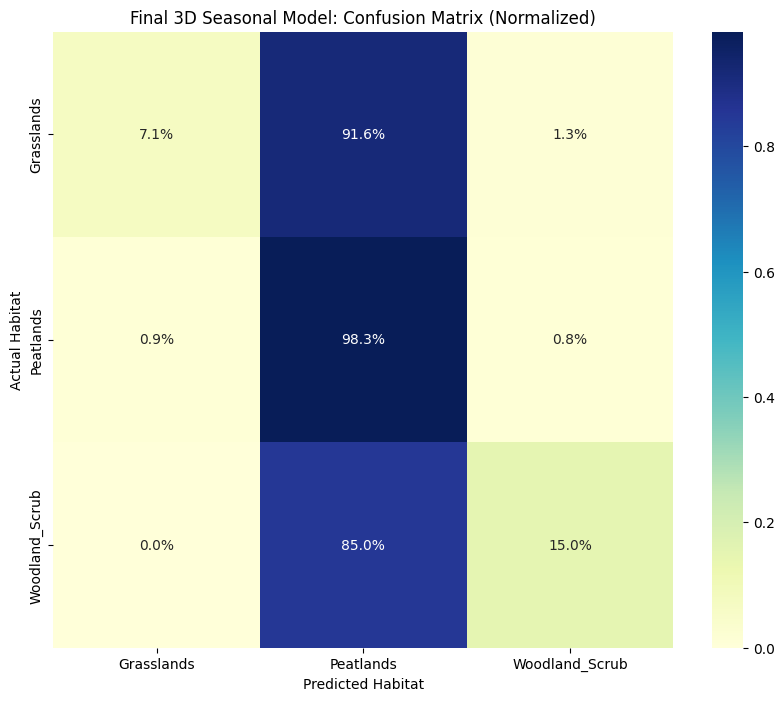

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()